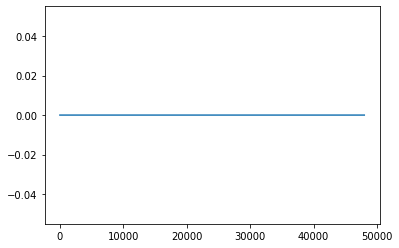

In [23]:
import importlib
import filters
importlib.reload(filters)
import IPython.display as ipd
import numpy as np
from matplotlib import pyplot as plt
from ctypes import c_double

def plotEq(f_x, x_arr, title, xlabel, ylabel):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_arr, f_x)

def DTFT(x, M):
    """
    Parameters:
    ---
    x: a signal which is assumed to start at time n = 0
    M: the number of output points of the DTFT

    Returns:
    ---
    X: the samples of the DTFT
    w: corresponding frequencies of these samples
    """
    N = max(M, len(x))
    N = int(np.power(2, np.ceil(np.log(N) / np.log(2))))
    X = np.fft.fft(x, N)
    w = np.arange(N) / N * 2 * np.pi
    w = w - 2 * np.pi * (w >= np.pi).astype(int)
    X = np.fft.fftshift(X)
    w = np.fft.fftshift(w)
    return X, w

FILTER_LOWPASS = 0
FILTER_HIGHPASS = 1
FILTER_BANDPASS = 2
FILTER_NOTCH = 3

# Define the parameters for sine wave
amplitude = 10.0  # Amplitude of the sine wave
frequency = 200.0  # Frequency of the sine wave in Hz
duration = 1.0   # Duration of the signal in seconds
sample_rate = 48000  # Number of samples per second

# Generate time values from 0 to duration with specified sample rate
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate the sine wave
y = amplitude * np.sin(2 * np.pi * frequency * t) # 200Hz sine
z = amplitude * np.sin(2 * np.pi * frequency * 2 * t) #400Hz sine

noisy_signal = (c_double * len(t))()
filtered_signal = (c_double * len(t))()

for i in range(len(t)):
    noisy_signal[i] = y[i] + z[i]
    filtered_signal[i] = 0.0

params = filters.get_params(FILTER_LOWPASS, 48000, 300, 0, 0.5)
filters.filter(noisy_signal, filtered_signal, 3, params)

plotEq(np.array(filtered_signal), np.arange(len(t)), "","","")